In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from jax import config

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"

In [3]:
from copy import deepcopy
import pickle
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit, value_and_grad, vmap
import optax
import tensorflow as tf
import tensorflow_datasets as tfds

import jaxley as jx
from jaxley.channels import HH
from jaxley.optimize import TypeOptimizer

In [4]:
n_train = 32
n_test = 16
seed = 0
batch_size = 1
stims_in_layers = 1
switch_labels = 0
depth = 2
data_std = 0.1
nseg_per_branch = 4

dt = 0.025
t_max = 5.95
i_delay = 1.0
i_dur = 0.9
i_amp = 0.05

time_vec = np.arange(0, t_max+2*dt, dt)

### Helper functions

In [5]:
def gen_data(n_data=3_000, switch_labels: int = 0, std: float = 0.1, center_x: float = 2.0, center_y: float = 2.0, spacing: float = 1.0):
    """Generate training data."""

    num_blobs = 3

    x_locs = np.linspace(center_x - spacing, center_x + spacing, num_blobs)
    y_locs = np.linspace(center_y + spacing, center_y - spacing, num_blobs)
    
    blobs_pos = []
    blobs_neg = []
    class_label = []
    for blob in range(num_blobs):
        xs = np.random.randn(n_data) * std + x_locs[blob]
        ys = np.random.randn(n_data) * std + y_locs[blob]
        
        if not blob % 2:
            blobs_pos.append(np.stack([xs, ys]).T)
        else:
            blobs_neg.append(np.stack([xs, ys]).T)

    class0 = np.concatenate(blobs_pos)
    class1 = np.concatenate(blobs_neg)

    inds = np.random.permutation(np.arange(len(class0)))
    class0 = class0[inds][: n_data // 2]
    inds = np.random.permutation(np.arange(len(class1)))
    class1 = class1[inds][: n_data // 2]

    all_data = np.concatenate([class0, class1])
    if switch_labels:
        all_labels = np.concatenate([np.zeros(n_data // 2), np.ones(n_data // 2)])
    else:
        all_labels = np.concatenate([np.ones(n_data // 2), np.zeros(n_data // 2)])

    inds = np.random.permutation(np.arange(len(all_labels)))
    all_data = all_data[inds]
    all_labels = all_labels[inds]
    all_voltage_labels = deepcopy(all_labels)

    all_voltage_labels[all_voltage_labels == 0] = -70.0
    all_voltage_labels[all_voltage_labels == 1] = 35.0

    return all_data, all_labels, all_voltage_labels


In [6]:
parents = [-1] + [b // 2 for b in range(0, 2**depth - 2)]
parents = jnp.asarray(parents)

num_branches = len(parents)

comp = jx.Compartment().initialize()
branch = jx.Branch([comp for _ in range(nseg_per_branch)]).initialize()
cell = jx.Cell([branch for _ in range(num_branches)], parents=parents).initialize()

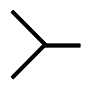

In [7]:
cell.compute_xyz()
cell.rotate(180)

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(0.92, 0.92))
    ax = cell.vis(ax=ax, morph_plot_kwargs={"linewidth": 2.5})
    _ = ax.spines["left"].set_visible(False)
    _ = ax.spines["bottom"].set_visible(False)
    _ = ax.set_xticks([])
    _ = ax.set_yticks([])
    # plt.savefig("results/figs/fig1/svg/simple_morph.svg", dpi=200, bbox_inches="tight")

In [8]:
def build_cell():
    parents = [-1] + [b // 2 for b in range(0, 2**depth - 2)]
    parents = jnp.asarray(parents)
    
    num_branches = len(parents)
    
    comp = jx.Compartment().initialize()
    branch = jx.Branch([comp for _ in range(nseg_per_branch)]).initialize()
    cell = jx.Cell([branch for _ in range(num_branches)], parents=parents).initialize()
    
    cell.insert(HH())
    
    cell.set("v", -70.0)
    cell.set("HH_m", 0.074901)
    cell.set("HH_h", 0.4889)
    cell.set("HH_n", 0.3644787)
    
    cell.branch(0).loc(0.0).record()
    
    cell.branch("all").comp("all").make_trainable(
        "radius", np.random.rand() * 4.5 + 0.1
    )
    cell.branch("all").comp("all").make_trainable(
        "length", np.random.rand() * 10.0 + 1.0
    )
    cell.branch("all").comp("all").make_trainable(
        "axial_resistivity", np.random.rand() * 5000.0 + 500.0
    )
    cell.branch("all").comp("all").make_trainable("HH_gNa", np.random.rand() * 1.0 + 0.05)
    cell.branch("all").comp("all").make_trainable("HH_gK", np.random.rand() * 0.25 + 0.01)
    cell.branch("all").comp("all").make_trainable(
        "HH_gLeak", np.random.rand() * 0.0008 + 0.0001
    )
    return cell

In [9]:
def simulate(params, image):
    currents = jx.datapoint_to_step_currents(i_delay, i_dur, i_amp * image, dt, t_max)

    data_stimuli = None
    for i, current in zip(range(2 * num_repeats), currents):
        data_stimuli = cell.branch(stim_branches[i]).loc(stim_locs[i]).data_stimulate(current, data_stimuli=data_stimuli)

    s = jx.integrate(cell, params=params, data_stimuli=data_stimuli)
    return s

vmapped_sim = vmap(simulate, in_axes=(None, 0))
jitted_sim = jit(vmapped_sim)

def predict(params, image):
    s = simulate(params, image)
    return s[0, 120]

batched_predict = vmap(predict, in_axes=(None, 0))
jitted_batched_predict = jit(batched_predict)

def loss_fn(params, images, labels):
    predictions = batched_predict(transform.forward(params), images)
    errors = jnp.abs(predictions - labels)
    return jnp.sum(errors)

loss_vmapped = jit(vmap(loss_fn, in_axes=(0, None, None)))

In [10]:
def evaluate(params):
    all_traces = []
    all_labels = []
    for batch in dataset_test:
        image_batch, label_batch = tfds.as_numpy(batch)
        sim_outs = jitted_sim(params, image_batch)
        all_traces.append(sim_outs)
        all_labels.append(label_batch)
    return jnp.concatenate(all_traces), jnp.stack(all_labels)
    
def vis_traces(traces, time_vec, labels):
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    for i, trace in enumerate(traces):
        col = "k" if labels[i] != -70.0 else "#d7301f"
        _ = ax.plot(time_vec, trace[0, :-1], c=col, linewidth=0.4, alpha=0.4)
        _ = ax.set_xlim([0, max(time_vec)])
        _ = ax.set_ylim([-80, 50])
        _ = ax.set_xlabel("Time (ms)")
        _ = ax.set_ylabel("Voltage (mV)")

In [11]:
def decision_surface(params, resolution=10):
    datax = np.linspace(0.0, 5.0, resolution)
    datay = np.linspace(0.0, 5.0, resolution)
    X, Y = np.meshgrid(datax, datay)
    stacked = np.stack([X, Y])
    xy = np.reshape(stacked, (2, resolution**2)).T
    xy = np.tile(xy, num_repeats)
    predictions_on_grid = jitted_batched_predict(params, xy)

    predictions = np.reshape(predictions_on_grid, (resolution, resolution))
    return predictions


def vis_decision_surface(predictions):
    fig, ax = plt.subplots(1, 1, figsize=(1.4, 0.92))
    p = ax.imshow(
        predictions,
        origin="lower",
        extent=[0, 5, 0, 5],
        vmin=-80.0,
        vmax=50.0,
    )
    cb = plt.colorbar(p, ticks=[-80, 50])
    return ax, cb

### Define curriculums for curriculum learning

In [12]:
stim_branches = np.concatenate(
    [
        np.arange(2 ** (depth + v) - 1, 2 ** (depth + v + 1) - 1)
        for v in range(-stims_in_layers, 0)
    ]
)
num_repeats = len(stim_branches) // 2
stim_locs = 1.0 * np.ones(2 * num_repeats)

lowers = {
    "radius": 0.1,
    "length": 1.0,
    "axial_resistivity": 500.0,
    "HH_gNa": 0.05,
    "HH_gK": 0.01,
    "HH_gLeak": 0.0001,
}
uppers = {
    "radius": 5.0,
    "length": 20.0,
    "axial_resistivity": 5500.0,
    "HH_gNa": 1.1,
    "HH_gK": 0.3,
    "HH_gLeak": 0.001,
}
transform = jx.ParamTransform(
    lowers=lowers,
    uppers=uppers,
)

In [13]:
# Works from scratch
center_x1 = 2.5
center_y1 = 2.5
spacing1 = 1.0

center_x2 = 1.0
center_y2 = 3.1
spacing2 = 0.9

centers_x = [center_x1, center_x2]
centers_y = [center_y1, center_y2]
spacings = [spacing1, spacing2]

lr = 0.01

### Train

In [14]:
from copy import deepcopy

New cell
Added 1 recordings. See `.recordings` for details.
Number of newly added trainable parameters: 12. Total number of trainable parameters: 12
Number of newly added trainable parameters: 12. Total number of trainable parameters: 24
Number of newly added trainable parameters: 12. Total number of trainable parameters: 36
Number of newly added trainable parameters: 12. Total number of trainable parameters: 48
Number of newly added trainable parameters: 12. Total number of trainable parameters: 60
Number of newly added trainable parameters: 12. Total number of trainable parameters: 72


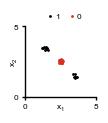

1588.2060546109797,
1581.140292594862,
1595.9584982642236,
1516.723799613028,
1422.6038930849654,
1402.1243426797741,
1299.9549933714975,
1459.623082896296,
1443.8010504810413,
784.0909545706136,
1156.6345495007722,
500.0464080673271,
901.6891358402686,
1055.6458700971853,
754.557874002192,
1259.6559357694127,
580.1025595731383,
884.6841831201957,
1032.355186306993,
389.901798827071,
729.2917687761185,
1371.8894937974794,
461.62364707961535,
564.8107874893429,
205.72764072175488,
486.7832597716094,
464.44483371049637,
634.1925853077146,
637.650355178952,
210.91214580415377,
718.9594220845217,
214.18288674191973,
143.4657776857879,
846.6515451280178,
240.19316920909753,
694.8417912680255,
549.626453587222,
1031.2188749442525,
1042.1794964246058,
348.23007011569973,
256.8739695579475,
128.559256786819,
351.8958745002045,
750.3966314561858,
229.34712474896514,
133.5905813720933,
151.72072766237648,
786.7036194297082,
137.6886479730029,
777.9703387510009,
382.4751777630515,
248.70916301810

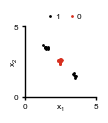

1554.167194461652,
1616.0589320133327,
1252.166497607499,
1361.1100622971103,
1028.5318762986508,
1371.351805157798,
1398.6597302628497,
989.3135849327239,
1034.0653357231606,
1016.8932351632304,
1023.3486176783788,
951.1240047643237,
1015.5512897335923,
986.1458484672804,
1065.1997405868854,
973.7947990302864,
761.439720163232,
314.14818142788414,
662.2787703219124,
758.3069135186573,
611.2965268023972,
722.0723706674054,
615.06716462297,
714.5439985657807,
850.6662936572877,
535.3925859633065,
804.449359902473,
286.2620665852922,
384.0382978994403,
654.8674577713202,
954.7467502823307,
588.5397936524669,
245.96522994821666,
600.6784231343989,
395.73322127843824,
219.14577731258623,
350.2793370702652,
627.2184553386365,
203.96344671681732,
207.86326572402317,
976.8810027089203,
226.40163185014254,
228.31457943031117,
548.1825235265752,
341.96933234316845,
329.7052077799538,
256.8280592297605,
408.31735984973926,
381.973738966412,
358.6963010797639,
242.09479710627113,
860.633529705755

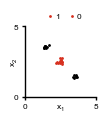

1559.9990481603886,
1673.821138459252,
1478.5746082367964,
1297.4522800065708,
1235.8859353507075,
690.4094864993315,
705.6118208712467,
347.60315451718463,
324.1921194824629,
475.7926404106423,
458.38294247789105,
711.6676372854035,
433.8652602329445,
500.48985338389264,
478.8224634318298,
467.587679285178,
476.449045697442,
525.2168514234082,
813.1576094781931,
1107.805580821331,
1194.3276239457964,
722.5842730784475,
702.2409976163472,
272.0957310285661,
229.04106049148174,
754.400828337401,
375.81310019521425,
530.4582754850628,
524.4264225442482,
833.1340562346916,
219.77361419999588,
217.06089971917532,
172.05018876235587,
209.84419338856816,
230.49628149785218,
364.7354135511292,
260.0814440832034,
162.39879387272615,
294.07911901114755,
374.76164512465874,
367.3942193705856,
322.8568591566352,
327.5690465607306,
349.6598072574784,
334.80986458348536,
380.5852030574408,
173.25286530329234,
178.7870591272641,
312.44279509521994,
508.6000426267434,
685.0693337361554,
673.220347280

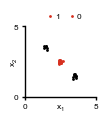

1517.6032463314864,
819.7105485387438,
1020.6774319502997,
861.9027807936745,
804.1470626766087,
792.7874600979499,
789.9978971411367,
810.0775779001738,
782.6158553947338,
796.6699264196533,
817.9121379041694,
779.6320648672811,
794.0671990952337,
772.695570109659,
787.2963492421445,
782.7372377906645,
774.269490414958,
781.923990225399,
773.574140707455,
768.4252277674982,
880.8416515150892,
771.1581404777663,
763.1032357871917,
778.5327278386903,
766.521785392285,
775.079518724129,
776.2718543352318,
770.9334195651845,
776.1656826581925,
762.6205696218158,
785.4545098234545,
769.9151858390167,
832.5400959664098,
753.954627199914,
758.2328871902581,
755.0757493598344,
749.909396258663,
751.0142515446945,
751.8902467874058,
792.2085685005572,
752.6909405679442,
742.7569639170661,
732.8543346257592,
488.7510296916716,
736.3444765544215,
852.2060381491353,
515.2263597698505,
724.7726191214915,
486.5122666054128,
808.3793101888648,
485.33559637325425,
171.9141419932688,
309.3073945925292

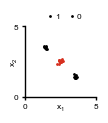

1128.1060146298025,
1678.3775634515807,
877.6069338592199,
466.53905586271173,
856.7495052153255,
904.1054777986226,
261.35306091080344,
474.37756083591347,
896.6639472909172,
175.5188540665692,
267.8164611983374,
242.99259571676956,
109.12350047701882,
369.8197457205,
91.24072474778137,
887.0462537448308,
191.43560187699532,
80.53614697142856,
142.80527878277127,
236.73571384910144,
479.99486863856043,
127.34238080115608,
875.3410699099139,
84.48202802223668,
97.88764660280975,
296.70319060160944,
82.35018158538256,
59.32828779877772,
76.70197827238025,
91.65213734336496,
66.62407246706672,
614.2346883380674,
183.94822825987058,
56.76806738082652,
640.7989507563024,
70.97447091858712,
52.518018065807496,
262.46221511663634,
377.48803945281537,
881.5020365837532,
247.46625501660657,
216.7218141520199,
299.6640620905811,
97.35570191396533,
76.42685060994287,
631.2616555013967,
114.0357928006495,
390.70327416793236,
242.69649272824014,
98.00088448467983,
324.9324303293465,
139.6661538224

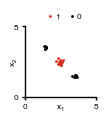

1627.7560694055478,
1554.9510737103565,
986.9185637871292,
914.91843197087,
895.1924977551193,
907.9320857908281,
895.9257421662012,
838.1619358492933,
896.8174080695981,
883.5738455151593,
873.9437774274709,
769.5097592251677,
825.9253362032779,
647.7762142169931,
719.5159137184635,
498.2233550328758,
492.81135649079624,
754.049924197431,
812.6109412590397,
527.4462023361848,
883.7593726495256,
887.7068963565503,
666.6969429136855,
233.8690295519914,
326.5013020796059,
555.5040168674641,
162.1341154626808,
260.705840817365,
210.22277466916427,
302.00739235780804,
399.9308653860501,
163.52168963682223,
199.1818738778494,
183.08170145292547,
151.35745670516013,
742.9734546511418,
146.9869132001728,
163.72284267481314,
270.1680107223417,
556.38687010103,
183.85003116464486,
133.51415818075915,
151.48554603804877,
563.7879227990121,
118.97512239268194,
238.21432227194052,
123.54847263700199,
128.87154100015326,
109.9026216828452,
183.2883148751508,
682.1565269890161,
117.98706938311784,
1

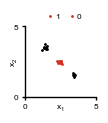

1262.9341186680037,
1672.2377167199097,
881.4010696127251,
307.67648352006165,
1168.8356506793598,
373.910494049463,
391.7739254651296,
431.4221708982328,
650.2250502152698,
169.20970432098432,
496.68862171393084,
178.8622449963916,
672.5216656546307,
299.4548481052151,
244.20982796083888,
216.70490838208963,
533.7995439267233,
1048.115402151599,
280.3122822273788,
676.560743395966,
326.472912731631,
181.12570848959535,
427.3288465949323,
227.08955655574397,
314.1397788366638,
176.1853545297119,
222.7270742851175,
350.66350149786365,
317.2254530438611,
644.3334152608535,
464.4083902907173,
430.90450741831745,
220.8916684400926,
380.00466542359675,
383.9273817528541,
262.6053384680366,
189.3986351291482,
164.68161678819263,
196.85501560597282,
278.5436441048343,
300.22414343319303,
536.7801975352901,
549.8755845959989,
291.00419651662,
428.44715876659427,
263.83295294550953,
287.4626526753397,
332.81128280390783,
221.58212357011777,
260.9264786346837,
460.4152649070662,
707.516049673248

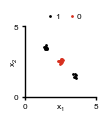

1025.8665387599108,
1253.735949608644,
1586.6113847281522,
1091.7234925085268,
711.4315006144502,
1151.15783770091,
824.2157484690915,
1454.3751090372377,
699.3314736256765,
718.9804033478785,
717.729187541236,
805.5158941991758,
680.3393239293217,
692.1783875941549,
733.2282908771954,
668.2974691428506,
656.6535948292046,
993.9006652474137,
692.2347211303647,
670.4724551542038,
707.158015374818,
675.9778387355194,
674.1835231165154,
1510.64752347166,
683.8991064109226,
681.1863648295018,
670.5882179948233,
672.8225123963707,
680.9630450347854,
681.1653718856871,
764.1047202710924,
707.5543470313164,
682.3763186481086,
660.5145629950092,
664.1194316108487,
658.0626699983035,
662.4694075147203,
643.4259299909221,
550.399857485163,
654.7682235225209,
647.9994747719846,
655.0959881981863,
646.6979640727772,
662.8937082186433,
656.5512275295489,
647.563305909066,
649.4228323648985,
654.213549454434,
510.85243148717075,
458.6409966666016,
385.0471980052753,
388.4453074374261,
647.7450498265

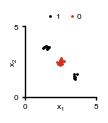

1374.739787126739,
1407.965615060978,
1508.012059044028,
1421.3232475623263,
964.3350221194113,
845.4163632066877,
809.1407507947085,
763.7135334696866,
711.7930182310524,
739.7262147184799,
785.3787350779365,
775.4305768249692,
850.3362458442728,
778.9288978353379,
713.4863650270709,
789.6173532772603,
797.4341889631295,
745.8953481243555,
735.4295800461571,
772.4665204431925,
750.887057693998,
745.200795781027,
743.6093934702112,
733.6625736209647,
743.0130886355321,
1036.6390387755823,
735.4203818166543,
822.6287049436141,
797.6652962874111,
715.2565472961028,
986.5854830685195,
817.2481588913547,
722.7354608328304,
735.3940101350809,
767.8443496321781,
721.1919344507234,
718.291598752817,
773.7051093381382,
714.2557644784697,
750.2525687641571,
873.211567183915,
713.9415837381226,
751.8615112524407,
715.4176861146804,
739.6714063778984,
709.4030131890141,
750.9760633371902,
749.0150558762261,
728.3565985081134,
697.362318520604,
692.1509625327067,
755.6397798032351,
755.86871981944

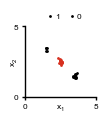

1208.2841320005014,
1676.229454959264,
1599.6581666473367,
820.420383619884,
672.1915398286277,
687.4834917595751,
681.3129876378255,
596.4323115674905,
639.3984292492321,
657.5622946027686,
638.9379175091183,
676.2123146180757,
688.0111906410268,
664.918527260692,
658.9298323195991,
632.9660718613353,
613.2341322477946,
667.6025073364387,
874.2166529931771,
620.9134149420443,
631.2285853830767,
608.3446410638549,
870.0465585311281,
610.9345442833196,
420.4340788028945,
670.8215583467081,
605.0015636474268,
467.13397698892027,
253.95909743275536,
368.8440320691356,
585.9946295744913,
270.0196777725728,
1019.5076691288809,
615.1128878046702,
193.77041429592205,
447.621128847349,
280.45543394637775,
639.5230114589481,
591.6413005007701,
540.0434842776563,
474.4528647835606,
277.5960904519985,
313.1551622304877,
229.22348520748307,
851.1502147058802,
643.4025874929011,
660.1123926330843,
593.7441200821987,
284.2916197452608,
697.0484685345118,
383.8547301837369,
197.04851691984732,
212.71

In [15]:
all_opt_params = []
counter = 0
all_ga_losses = []
for seed in range(10):
    ga_losses = []

    for center_x, center_y, spacing in zip(centers_x[:1], centers_y[:1], spacings[:1]):
        print("New cell")
        tf.random.set_seed(42 + seed)  # 39,40,41,42 works
        _ = np.random.seed(0 + seed) # 0 works
    
        cell = build_cell()
        params = cell.get_parameters()
        opt_params = transform.inverse(params)
    
        train_images, train_labels, train_voltages = gen_data(
            n_train, switch_labels=switch_labels, std=data_std, center_x=center_x, center_y=center_y, spacing=spacing,
        )
        test_images, _, test_voltages = gen_data(
            n_test, switch_labels=switch_labels, std=data_std, center_x=center_x, center_y=center_y, spacing=spacing,
        )
    
        train_images = np.tile(train_images, num_repeats)
        test_images = np.tile(test_images, num_repeats)
    
        with mpl.rc_context(fname="../../../.matplotlibrc"):
            fig, ax = plt.subplots(1, 1, figsize=(0.92, 0.92))
            for p, l in zip(train_images[:100], train_labels[:100]):
                _ = ax.scatter(p[0], p[1], c="k" if l else "#d7301f", s=1.0)
            _ = ax.set_xlim([0, 5])
            _ = ax.set_ylim([0, 5])
            _ = ax.set_xticks([0, 5])
            _ = ax.set_yticks([0, 5])
            _ = ax.set_xlabel(r"$x_1$", labelpad=-5)
            _ = ax.set_ylabel(r"$x_2$", labelpad=-5)
            _ = ax.legend(["1", "0"], loc="upper right", bbox_to_anchor=[0.9, 1.3, 0.0, 0.0],
                          ncols=2, columnspacing=0.4, handletextpad=-0.4)
    
            # plt.savefig(f"results/figs/fig1/svg/learned_data_simple_{counter}.svg", bbox_inches="tight", transparent=True)
            plt.show()
    
    
        import bluepyopt as bpopt
        from bluepyopt.parameters import Parameter
        
        class HHEvaluator(bpopt.evaluators.Evaluator):
            def __init__(self, x_labels, params):
                super().__init__(objectives=x_labels, params=params)
        
            def init_simulator_and_evaluate_with_lists(self, param_list):
                global ga_losses
                param_list = jnp.asarray(param_list)
                counter = 0
                names = ["radius", "length", "axial_resistivity", "HH_gNa", "HH_gK", "HH_gLeak"]
                params = []
                for name in names:
                    params.append({name: jnp.asarray(param_list[:, counter:counter+12])})
                    counter += 12
    
                opt_params = transform.inverse(params)
                losses = loss_vmapped(opt_params, train_images, train_voltages)
                ga_losses.append(np.min(losses).item())
                print(f"{np.min(losses)},")
                return losses[:, None].tolist()
        
        def map_fun(evaluate_with_lists, list_of_thetas):
            results = evaluate_with_lists(list_of_thetas)
            return results
    
        x_labels = ["loss"]
        params = []
        for key in lowers:
            for r in range(12):
                params.append(Parameter(f"{key}_{r}", bounds=[lowers[key], uppers[key]]))
    
        evaluator = HHEvaluator(x_labels, params)
        opt = bpopt.deapext.optimisations.IBEADEAPOptimisation(
            evaluator,
            offspring_size=10,
            map_function=map_fun,
            seed=seed,
            eta=10,
            mutpb=1.0,
            cxpb=1.0,
        )
        
        final_pop, halloffame, log, hist = opt.run(max_ngen=200)
        print("Finished")

    all_ga_losses.append(deepcopy(ga_losses))

In [17]:
with open("../results/04_nonlinear/ga_loss.pkl", "wb") as handle:
    pickle.dump(all_ga_losses, handle)